In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [216]:
df = pd.read_csv('/Users/stevenstrange/Desktop/final.csv').drop(columns='Unnamed: 0')
dfhyper = pd.read_csv('/Users/stevenstrange/hyper.csv').drop(columns='Unnamed: 0')
train = pd.read_csv('/Users/stevenstrange/Downloads/train_with_top_feats_350.csv').drop(columns='Unnamed: 0')
df2 = pd.read_csv('/Users/stevenstrange/Downloads/valid_with_top_feats_350.csv').drop(columns='Unnamed: 0')
X_train = train
y_train = df['311']
X_val = df2
y_val = dfhyper['target']

/var/folders/h1/d6gbh22941z2_4t47cbrzl680000gn/T/ipykernel_87276/3670099111.py:2: DtypeWarning: Columns (313) have mixed types. Specify dtype option on import or set low_memory=False.
  dfhyper = pd.read_csv('/Users/stevenstrange/hyper.csv').drop(columns='Unnamed: 0')


In [83]:
def kmeans_clustering(df):
    k = 10
    kmeans = KMeans(n_clusters=k, n_init = 20)
    clusters = kmeans.fit_predict(df)
    new_df = df.copy()
    new_df['Cluster'] = clusters
    cluster_centers = kmeans.cluster_centers_

    return new_df, cluster_centers


def add_nearest_cluster(test_df, cluster_centers):
    new_test_df = test_df.copy()
    distances = cdist(new_test_df.values, cluster_centers)
    nearest_clusters = distances.argmin(axis=1)
    new_test_df['Cluster'] = nearest_clusters

    return new_test_df

clustered_train, centroids = kmeans_clustering(df.iloc[:,:311])



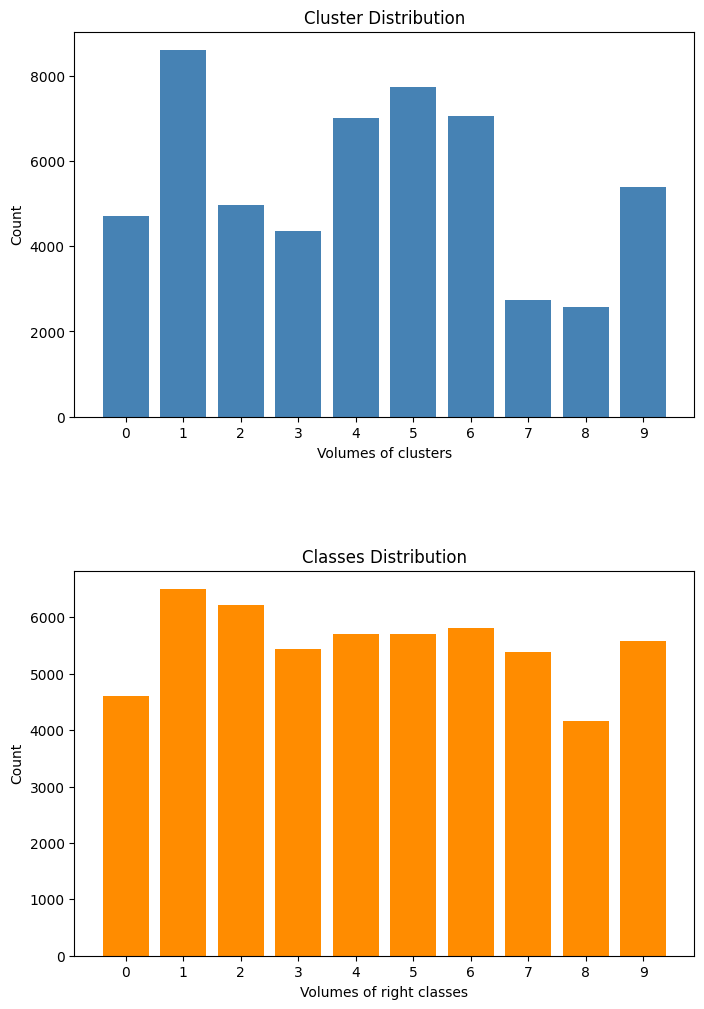

In [58]:
import matplotlib.pyplot as plt

# Создание фигуры и осей
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Первый график - распределение кластеров
axes[0].bar(clustered_train['Cluster'].value_counts().index, clustered_train['Cluster'].value_counts(), color='steelblue')
axes[0].set_xlabel('Volumes of clusters')
axes[0].set_ylabel('Count')
axes[0].set_title('Cluster Distribution')
axes[0].set_xticks(clustered_train['Cluster'].value_counts().index)
axes[0].tick_params(axis='x', rotation=0)

# Второй график - распределение классов
axes[1].bar(y_train.value_counts().index, y_train.value_counts(), color='darkorange')
axes[1].set_xlabel('Volumes of right classes')
axes[1].set_ylabel('Count')
axes[1].set_title('Classes Distribution')
axes[1].set_xticks(y_train.value_counts().index)
axes[1].tick_params(axis='x', rotation=0)

# Установка расстояния между подграфиками
plt.subplots_adjust(hspace=0.4)

# Отображение графиков
plt.show()


Выглядит не очень. Применим SMOTE

In [60]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled,y_resampled = smote.fit_resample(df.iloc[:,:311],df['311'])
X_resampled.shape

(65020, 311)

In [61]:
clustered_train_smote, centroids_smote = kmeans_clustering(X_resampled)

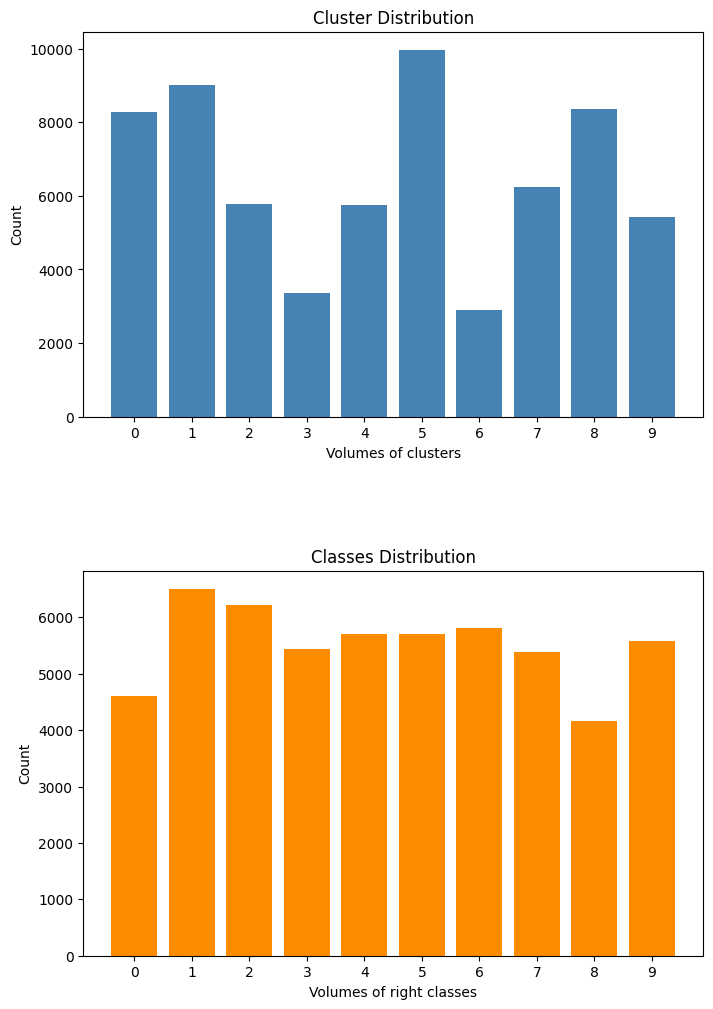

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Первый график - распределение кластеров
axes[0].bar(clustered_train_smote['Cluster'].value_counts().index, clustered_train_smote['Cluster'].value_counts(), color='steelblue')
axes[0].set_xlabel('Volumes of clusters')
axes[0].set_ylabel('Count')
axes[0].set_title('Cluster Distribution')
axes[0].set_xticks(clustered_train_smote['Cluster'].value_counts().index)
axes[0].tick_params(axis='x', rotation=0)

# Второй график - распределение классов
axes[1].bar(y_train.value_counts().index, y_train.value_counts(), color='darkorange')
axes[1].set_xlabel('Volumes of right classes')
axes[1].set_ylabel('Count')
axes[1].set_title('Classes Distribution')
axes[1].set_xticks(y_train.value_counts().index)
axes[1].tick_params(axis='x', rotation=0)

# Установка расстояния между подграфиками
plt.subplots_adjust(hspace=0.4)

# Отображение графиков
plt.show()

После того, как мы избавились от дисбаланса, ситуация с кластерами чуть улучшилась

Обучим кэтбуст на X_train и проверим на валидационной

In [77]:
X_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)
X_train_smote['Cluster'] = clustered_train_smote['Cluster']


/var/folders/h1/d6gbh22941z2_4t47cbrzl680000gn/T/ipykernel_87276/74248555.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_smote['Cluster'] = clustered_train_smote['Cluster']


(65020, 351)

In [80]:
X_val_311 = dfhyper.iloc[:,:311]

In [88]:
clusters_311_val = add_nearest_cluster(X_val_311,centroids_smote)
X_val['Cluster']=clusters_311_val['Cluster']

In [91]:
from catboost import CatBoostClassifier
catboost = CatBoostClassifier()
catboost.fit(X_train,y_train)

Learning rate set to 0.097081
0:	learn: 2.1518283	total: 731ms	remaining: 12m 10s
1:	learn: 2.0419642	total: 1.39s	remaining: 11m 34s
2:	learn: 1.9514765	total: 2.02s	remaining: 11m 12s
3:	learn: 1.8834395	total: 2.68s	remaining: 11m 6s
4:	learn: 1.8201553	total: 3.34s	remaining: 11m 5s
5:	learn: 1.7665542	total: 4.02s	remaining: 11m 5s
6:	learn: 1.7245952	total: 4.69s	remaining: 11m 5s
7:	learn: 1.6851191	total: 5.36s	remaining: 11m 4s
8:	learn: 1.6536789	total: 6.03s	remaining: 11m 4s
9:	learn: 1.6201184	total: 6.77s	remaining: 11m 10s
10:	learn: 1.5900059	total: 7.62s	remaining: 11m 24s
11:	learn: 1.5621376	total: 8.48s	remaining: 11m 37s
12:	learn: 1.5365084	total: 9.27s	remaining: 11m 43s
13:	learn: 1.5122279	total: 10.1s	remaining: 11m 48s
14:	learn: 1.4892020	total: 10.8s	remaining: 11m 49s
15:	learn: 1.4692551	total: 11.6s	remaining: 11m 51s
16:	learn: 1.4505679	total: 12.3s	remaining: 11m 53s
17:	learn: 1.4326006	total: 13s	remaining: 11m 51s
18:	learn: 1.4152480	total: 13.8s	

153:	learn: 0.7755712	total: 2m 6s	remaining: 11m 34s
154:	learn: 0.7727063	total: 2m 7s	remaining: 11m 33s
155:	learn: 0.7703543	total: 2m 8s	remaining: 11m 33s
156:	learn: 0.7687194	total: 2m 8s	remaining: 11m 32s
157:	learn: 0.7665317	total: 2m 9s	remaining: 11m 31s
158:	learn: 0.7640369	total: 2m 10s	remaining: 11m 31s
159:	learn: 0.7622260	total: 2m 11s	remaining: 11m 30s
160:	learn: 0.7600061	total: 2m 12s	remaining: 11m 30s
161:	learn: 0.7582198	total: 2m 13s	remaining: 11m 30s
162:	learn: 0.7547767	total: 2m 14s	remaining: 11m 29s
163:	learn: 0.7523539	total: 2m 15s	remaining: 11m 29s
164:	learn: 0.7499245	total: 2m 16s	remaining: 11m 28s
165:	learn: 0.7476521	total: 2m 17s	remaining: 11m 29s
166:	learn: 0.7452927	total: 2m 18s	remaining: 11m 28s
167:	learn: 0.7430432	total: 2m 18s	remaining: 11m 27s
168:	learn: 0.7408975	total: 2m 19s	remaining: 11m 27s
169:	learn: 0.7385855	total: 2m 20s	remaining: 11m 26s
170:	learn: 0.7368534	total: 2m 21s	remaining: 11m 26s
171:	learn: 0.7

304:	learn: 0.5472861	total: 4m 16s	remaining: 9m 44s
305:	learn: 0.5459727	total: 4m 17s	remaining: 9m 43s
306:	learn: 0.5451367	total: 4m 18s	remaining: 9m 42s
307:	learn: 0.5438494	total: 4m 18s	remaining: 9m 41s
308:	learn: 0.5427167	total: 4m 19s	remaining: 9m 40s
309:	learn: 0.5409289	total: 4m 20s	remaining: 9m 40s
310:	learn: 0.5393548	total: 4m 21s	remaining: 9m 39s
311:	learn: 0.5388179	total: 4m 22s	remaining: 9m 38s
312:	learn: 0.5373205	total: 4m 23s	remaining: 9m 37s
313:	learn: 0.5359629	total: 4m 23s	remaining: 9m 36s
314:	learn: 0.5354165	total: 4m 24s	remaining: 9m 35s
315:	learn: 0.5343907	total: 4m 25s	remaining: 9m 34s
316:	learn: 0.5337052	total: 4m 26s	remaining: 9m 33s
317:	learn: 0.5330563	total: 4m 27s	remaining: 9m 32s
318:	learn: 0.5321924	total: 4m 27s	remaining: 9m 32s
319:	learn: 0.5315683	total: 4m 28s	remaining: 9m 31s
320:	learn: 0.5306300	total: 4m 29s	remaining: 9m 30s
321:	learn: 0.5292618	total: 4m 30s	remaining: 9m 29s
322:	learn: 0.5284656	total:

457:	learn: 0.4351591	total: 6m 20s	remaining: 7m 30s
458:	learn: 0.4347146	total: 6m 21s	remaining: 7m 29s
459:	learn: 0.4338537	total: 6m 22s	remaining: 7m 29s
460:	learn: 0.4332651	total: 6m 23s	remaining: 7m 28s
461:	learn: 0.4325351	total: 6m 24s	remaining: 7m 27s
462:	learn: 0.4321783	total: 6m 25s	remaining: 7m 26s
463:	learn: 0.4318205	total: 6m 25s	remaining: 7m 25s
464:	learn: 0.4313709	total: 6m 26s	remaining: 7m 24s
465:	learn: 0.4310771	total: 6m 27s	remaining: 7m 23s
466:	learn: 0.4303881	total: 6m 28s	remaining: 7m 23s
467:	learn: 0.4298202	total: 6m 29s	remaining: 7m 22s
468:	learn: 0.4294633	total: 6m 29s	remaining: 7m 21s
469:	learn: 0.4290717	total: 6m 30s	remaining: 7m 20s
470:	learn: 0.4286296	total: 6m 31s	remaining: 7m 19s
471:	learn: 0.4280796	total: 6m 32s	remaining: 7m 18s
472:	learn: 0.4278886	total: 6m 33s	remaining: 7m 17s
473:	learn: 0.4276084	total: 6m 33s	remaining: 7m 17s
474:	learn: 0.4265001	total: 6m 34s	remaining: 7m 16s
475:	learn: 0.4256028	total:

610:	learn: 0.3653889	total: 8m 30s	remaining: 5m 24s
611:	learn: 0.3649206	total: 8m 31s	remaining: 5m 24s
612:	learn: 0.3646627	total: 8m 32s	remaining: 5m 23s
613:	learn: 0.3643003	total: 8m 33s	remaining: 5m 22s
614:	learn: 0.3636944	total: 8m 34s	remaining: 5m 21s
615:	learn: 0.3634455	total: 8m 35s	remaining: 5m 21s
616:	learn: 0.3632407	total: 8m 35s	remaining: 5m 20s
617:	learn: 0.3629124	total: 8m 36s	remaining: 5m 19s
618:	learn: 0.3626591	total: 8m 37s	remaining: 5m 18s
619:	learn: 0.3624718	total: 8m 38s	remaining: 5m 17s
620:	learn: 0.3621697	total: 8m 39s	remaining: 5m 16s
621:	learn: 0.3609292	total: 8m 39s	remaining: 5m 15s
622:	learn: 0.3605855	total: 8m 40s	remaining: 5m 15s
623:	learn: 0.3600148	total: 8m 41s	remaining: 5m 14s
624:	learn: 0.3595899	total: 8m 42s	remaining: 5m 13s
625:	learn: 0.3592328	total: 8m 43s	remaining: 5m 12s
626:	learn: 0.3587498	total: 8m 44s	remaining: 5m 11s
627:	learn: 0.3582846	total: 8m 44s	remaining: 5m 10s
628:	learn: 0.3578159	total:

762:	learn: 0.3194648	total: 10m 45s	remaining: 3m 20s
763:	learn: 0.3192353	total: 10m 45s	remaining: 3m 19s
764:	learn: 0.3190252	total: 10m 46s	remaining: 3m 18s
765:	learn: 0.3188532	total: 10m 47s	remaining: 3m 17s
766:	learn: 0.3185831	total: 10m 48s	remaining: 3m 16s
767:	learn: 0.3181145	total: 10m 49s	remaining: 3m 16s
768:	learn: 0.3178394	total: 10m 50s	remaining: 3m 15s
769:	learn: 0.3176167	total: 10m 50s	remaining: 3m 14s
770:	learn: 0.3174849	total: 10m 51s	remaining: 3m 13s
771:	learn: 0.3170689	total: 10m 52s	remaining: 3m 12s
772:	learn: 0.3169062	total: 10m 53s	remaining: 3m 11s
773:	learn: 0.3166973	total: 10m 54s	remaining: 3m 11s
774:	learn: 0.3164653	total: 10m 55s	remaining: 3m 10s
775:	learn: 0.3162564	total: 10m 55s	remaining: 3m 9s
776:	learn: 0.3159131	total: 10m 56s	remaining: 3m 8s
777:	learn: 0.3154666	total: 10m 57s	remaining: 3m 7s
778:	learn: 0.3152673	total: 10m 58s	remaining: 3m 6s
779:	learn: 0.3148604	total: 10m 59s	remaining: 3m 5s
780:	learn: 0.3

913:	learn: 0.2849308	total: 12m 58s	remaining: 1m 13s
914:	learn: 0.2848063	total: 12m 58s	remaining: 1m 12s
915:	learn: 0.2844187	total: 12m 59s	remaining: 1m 11s
916:	learn: 0.2842873	total: 13m	remaining: 1m 10s
917:	learn: 0.2841205	total: 13m 1s	remaining: 1m 9s
918:	learn: 0.2839874	total: 13m 2s	remaining: 1m 8s
919:	learn: 0.2839079	total: 13m 2s	remaining: 1m 8s
920:	learn: 0.2837709	total: 13m 3s	remaining: 1m 7s
921:	learn: 0.2836075	total: 13m 4s	remaining: 1m 6s
922:	learn: 0.2834615	total: 13m 5s	remaining: 1m 5s
923:	learn: 0.2833823	total: 13m 6s	remaining: 1m 4s
924:	learn: 0.2832374	total: 13m 6s	remaining: 1m 3s
925:	learn: 0.2831962	total: 13m 7s	remaining: 1m 2s
926:	learn: 0.2831602	total: 13m 8s	remaining: 1m 2s
927:	learn: 0.2830317	total: 13m 9s	remaining: 1m 1s
928:	learn: 0.2829395	total: 13m 10s	remaining: 1m
929:	learn: 0.2827867	total: 13m 10s	remaining: 59.5s
930:	learn: 0.2826428	total: 13m 11s	remaining: 58.7s
931:	learn: 0.2824821	total: 13m 12s	remai

In [96]:
roc_auc_score(y_val,catboost.predict_proba(X_val),multi_class='ovo')

0.8323795517329857

УРАААААА КАЧЕСТВО ВЫРОСЛООО

Посмотрим с помощью umap на точечный график для кластеров по каждому классу. Как для SMOTE, так и без него

In [183]:
import umap
def umapped(clustered_train):
    features = clustered_train.drop('Cluster', axis=1).values
    labels = clustered_train['Cluster'].values

    u = umap.UMAP(n_components=2)
    umap_result = u.fit_transform(features)
    return umap_result,labels

In [115]:
cluster_umap,clusters = umapped(clustered_train_smote)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [125]:
cluster_umap = pd.DataFrame(cluster_umap)
cluster_umap['Cluster'] = clusters
cluster_umap['target'] = y_train_smote.values

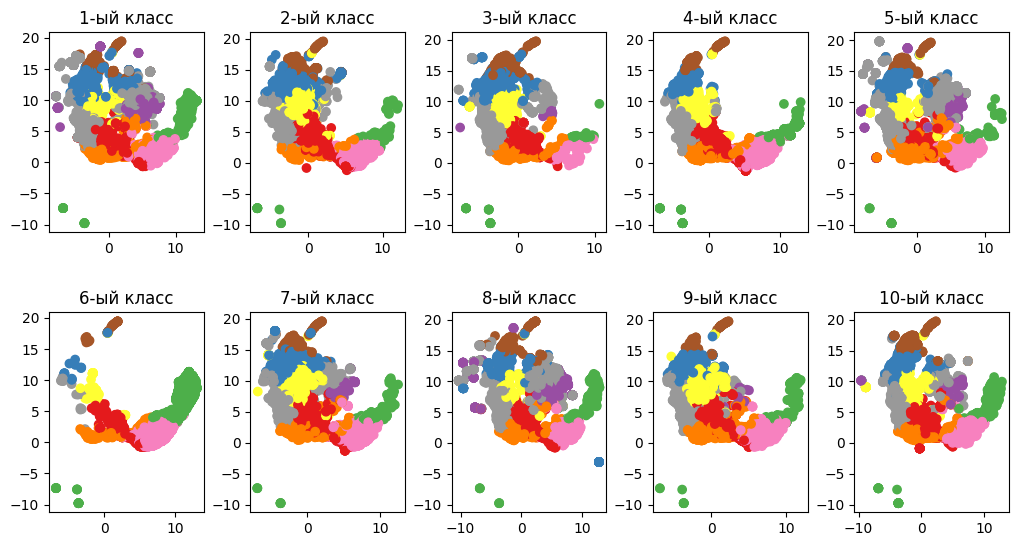

In [169]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

# Пример заполнения графиков данными
for i in range(10):
    if i < 5:
        ax = axes[0, i]
    else:
        ax = axes[1, i-5]
    ax.scatter(cluster_umap[cluster_umap.target==i][0], cluster_umap[cluster_umap.target==i][1], c=cluster_umap[cluster_umap.target==i].Cluster, cmap='Set1')
    ax.set_title(f'{i+1}-ый класс')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)


In [188]:
cluster_umap_nosmote,clusters_nosmote = umapped(clustered_train=clustered_train)
cluster_umap_nosmote = pd.DataFrame(cluster_umap_nosmote)
cluster_umap_nosmote['Cluster'] = clusters_nosmote
cluster_umap_nosmote['target'] = y_train.values

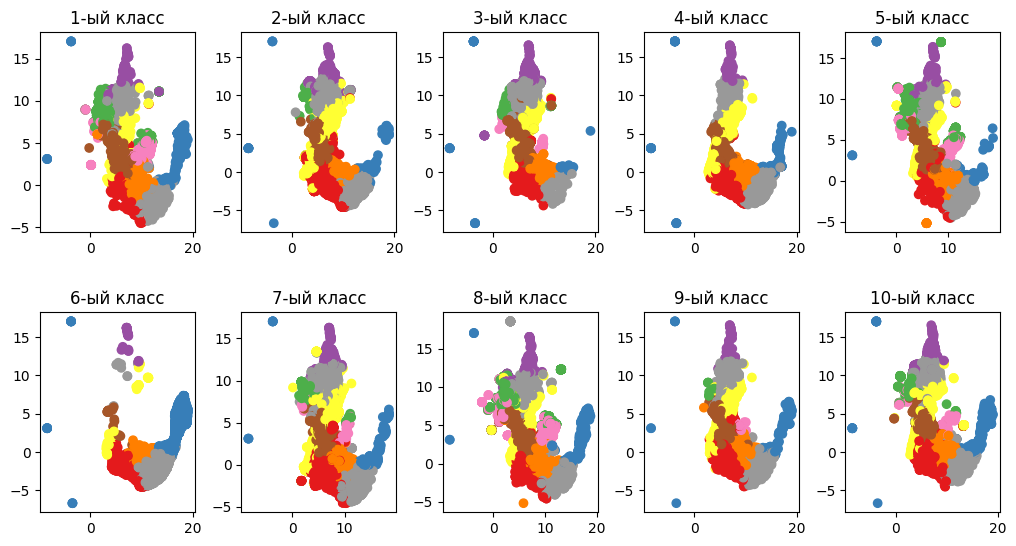

In [192]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(10):
    if i < 5:
        ax = axes[0, i]
    else:
        ax = axes[1, i-5]
    ax.scatter(cluster_umap_nosmote[cluster_umap_nosmote.target==i][0], cluster_umap_nosmote[cluster_umap_nosmote.target==i][1], c=cluster_umap_nosmote[cluster_umap_nosmote.target==i].Cluster, cmap='Set1')
    ax.set_title(f'{i+1}-ый класс')
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)



Судя по графикам, преобладающего количества в каждом классе довольно тяжело обнаружить. Поэтому ROC-AUC не так сильно и увеличился

In [226]:
import optuna
def objective(trial):
    # Определение пространства поиска гиперпараметров
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bootstrap_type': 'Bayesian',
    }
    model = CatBoostClassifier(**params, eval_metric='AUC', random_state=42, verbose=False)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=20)

    # Вычисление метрики для оптимизации
    y_pred = model.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_pred,multi_class='ovo')
    return auc

# Создание и запуск оптимизации с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,timeout=600)


[I 2023-06-14 23:01:38,506] A new study created in memory with name: no-name-277f9a7b-529c-4651-99c5-fb6fdd16e666
[I 2023-06-14 23:01:58,480] Trial 0 finished with value: 0.8202585267998229 and parameters: {'iterations': 410, 'depth': 5, 'learning_rate': 0.19373649173373586, 'l2_leaf_reg': 2.961024271270898, 'border_count': 57, 'bagging_temperature': 9.383800493217473, 'random_strength': 0.47002454375985225}. Best is trial 0 with value: 0.8202585267998229.
[I 2023-06-14 23:03:03,855] Trial 1 finished with value: 0.8177931426017194 and parameters: {'iterations': 440, 'depth': 7, 'learning_rate': 0.3709696100172101, 'l2_leaf_reg': 0.7930420919895442, 'border_count': 208, 'bagging_temperature': 3.348939713766066, 'random_strength': 1.982130792168808}. Best is trial 0 with value: 0.8202585267998229.
[I 2023-06-14 23:03:14,055] Trial 2 finished with value: 0.8190674579358761 and parameters: {'iterations': 172, 'depth': 1, 'learning_rate': 0.3513391812035134, 'l2_leaf_reg': 0.682525699487624

KeyboardInterrupt: 

Стопнули, думали, что timeout это максимум, который может работать optuna

In [227]:
params={'iterations': 813, 'depth': 9, 'learning_rate': 0.035725350729005435, 'l2_leaf_reg': 5.0649432679287685, 'border_count': 39, 'bagging_temperature': 2.216474196894726, 'random_strength': 4.031225793543406}
model = CatBoostClassifier(**params, eval_metric='AUC', random_state=42, verbose=True)
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=20)
y_pred = model.predict_proba(X_val)
roc_auc_score(y_val, y_pred,multi_class='ovo')

0:	test: 0.8092601	best: 0.8092601 (0)	total: 1.15s	remaining: 15m 37s
1:	test: 0.8212465	best: 0.8212465 (1)	total: 2.76s	remaining: 18m 40s
2:	test: 0.8269310	best: 0.8269310 (2)	total: 4.35s	remaining: 19m 33s
3:	test: 0.8304841	best: 0.8304841 (3)	total: 6.1s	remaining: 20m 33s
4:	test: 0.8360549	best: 0.8360549 (4)	total: 7.88s	remaining: 21m 12s
5:	test: 0.8397475	best: 0.8397475 (5)	total: 9.76s	remaining: 21m 52s
6:	test: 0.8419038	best: 0.8419038 (6)	total: 11.7s	remaining: 22m 30s
7:	test: 0.8419872	best: 0.8419872 (7)	total: 13.7s	remaining: 23m 1s
8:	test: 0.8428164	best: 0.8428164 (8)	total: 15.6s	remaining: 23m 15s
9:	test: 0.8442526	best: 0.8442526 (9)	total: 17.6s	remaining: 23m 30s
10:	test: 0.8445369	best: 0.8445369 (10)	total: 19.5s	remaining: 23m 40s
11:	test: 0.8460830	best: 0.8460830 (11)	total: 21.2s	remaining: 23m 36s
12:	test: 0.8479626	best: 0.8479626 (12)	total: 22.9s	remaining: 23m 32s
13:	test: 0.8485518	best: 0.8485518 (13)	total: 24.6s	remaining: 23m 26s


112:	test: 0.8704359	best: 0.8704359 (112)	total: 3m 36s	remaining: 22m 20s
113:	test: 0.8707330	best: 0.8707330 (113)	total: 3m 38s	remaining: 22m 20s
114:	test: 0.8711348	best: 0.8711348 (114)	total: 3m 40s	remaining: 22m 21s
115:	test: 0.8713317	best: 0.8713317 (115)	total: 3m 43s	remaining: 22m 20s
116:	test: 0.8713160	best: 0.8713317 (115)	total: 3m 45s	remaining: 22m 19s
117:	test: 0.8712254	best: 0.8713317 (115)	total: 3m 47s	remaining: 22m 18s
118:	test: 0.8713540	best: 0.8713540 (118)	total: 3m 49s	remaining: 22m 16s
119:	test: 0.8716214	best: 0.8716214 (119)	total: 3m 51s	remaining: 22m 14s
120:	test: 0.8718771	best: 0.8718771 (120)	total: 3m 52s	remaining: 22m 11s
121:	test: 0.8718713	best: 0.8718771 (120)	total: 3m 54s	remaining: 22m 8s
122:	test: 0.8718411	best: 0.8718771 (120)	total: 3m 56s	remaining: 22m 6s
123:	test: 0.8717789	best: 0.8718771 (120)	total: 3m 58s	remaining: 22m 3s
124:	test: 0.8720147	best: 0.8720147 (124)	total: 4m	remaining: 22m 1s
125:	test: 0.8721393

221:	test: 0.8775714	best: 0.8775714 (221)	total: 6m 56s	remaining: 18m 27s
222:	test: 0.8775558	best: 0.8775714 (221)	total: 6m 58s	remaining: 18m 26s
223:	test: 0.8776127	best: 0.8776127 (223)	total: 7m	remaining: 18m 25s
224:	test: 0.8777226	best: 0.8777226 (224)	total: 7m 2s	remaining: 18m 23s
225:	test: 0.8777193	best: 0.8777226 (224)	total: 7m 4s	remaining: 18m 21s
226:	test: 0.8777071	best: 0.8777226 (224)	total: 7m 6s	remaining: 18m 21s
227:	test: 0.8777394	best: 0.8777394 (227)	total: 7m 8s	remaining: 18m 19s
228:	test: 0.8778207	best: 0.8778207 (228)	total: 7m 10s	remaining: 18m 17s
229:	test: 0.8779012	best: 0.8779012 (229)	total: 7m 12s	remaining: 18m 15s
230:	test: 0.8780448	best: 0.8780448 (230)	total: 7m 13s	remaining: 18m 13s
231:	test: 0.8780724	best: 0.8780724 (231)	total: 7m 15s	remaining: 18m 10s
232:	test: 0.8781217	best: 0.8781217 (232)	total: 7m 17s	remaining: 18m 8s
233:	test: 0.8781099	best: 0.8781217 (232)	total: 7m 19s	remaining: 18m 6s
234:	test: 0.8780972	b

330:	test: 0.8820397	best: 0.8820670 (328)	total: 10m 1s	remaining: 14m 35s
331:	test: 0.8819989	best: 0.8820670 (328)	total: 10m 3s	remaining: 14m 33s
332:	test: 0.8820121	best: 0.8820670 (328)	total: 10m 4s	remaining: 14m 31s
333:	test: 0.8820598	best: 0.8820670 (328)	total: 10m 6s	remaining: 14m 29s
334:	test: 0.8820105	best: 0.8820670 (328)	total: 10m 7s	remaining: 14m 27s
335:	test: 0.8820234	best: 0.8820670 (328)	total: 10m 9s	remaining: 14m 25s
336:	test: 0.8821903	best: 0.8821903 (336)	total: 10m 11s	remaining: 14m 23s
337:	test: 0.8821759	best: 0.8821903 (336)	total: 10m 12s	remaining: 14m 21s
338:	test: 0.8821747	best: 0.8821903 (336)	total: 10m 14s	remaining: 14m 19s
339:	test: 0.8821388	best: 0.8821903 (336)	total: 10m 15s	remaining: 14m 16s
340:	test: 0.8821785	best: 0.8821903 (336)	total: 10m 17s	remaining: 14m 14s
341:	test: 0.8822239	best: 0.8822239 (341)	total: 10m 19s	remaining: 14m 12s
342:	test: 0.8821695	best: 0.8822239 (341)	total: 10m 20s	remaining: 14m 10s
343:	

0.8339306650683159

Получили максимальный для нас ROC AUC: 0.8339